In [ ]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 198 kB 47.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=e104fcd197d8ad2ea7974c93189517619e995c69da12195d7ee19c02a84ca523
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# pyspark - sparse matrix 

In [ ]:
from pyspark.sql import SparkSession
from scipy import sparse
import numpy as np
import pandas as pd

# creat a sparksession to read data on pyspark 
spark = SparkSession.builder.getOrCreate()
df_rdd = spark.read.csv('/content/drive/MyDrive/651/ml-1m/ratings.dat',sep = '::').toDF('userId', 'movieId','rating','timestamp')
# convert Dataframe to array
# sparse matrix requires to have 1-d array 
rows = np.array(df_rdd.select("userId").collect()).reshape(-1)
cols = np.array(df_rdd.select("movieId").collect()).reshape(-1)
data = np.array(df_rdd.select("rating").collect()).reshape(-1)

# converting array into sparse matrix format 
sparse_matrix = sparse.coo_matrix((data, (rows, cols)), shape=(len(rows), len(cols)), dtype= int)
sparse_matrix = sparse_matrix.tocsr()

# reading data in pandas for splitting dataset
ratings = pd.read_csv("/content/drive/MyDrive/651/ml-1m/ratings.dat",
                      sep = '::',
                      names = ['userId', 'movieId','rating','timestamp'],
                      encoding = 'latin-1')
ratings = ratings[['userId', 'movieId','rating']].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


#### Matrix Factorization

In [ ]:
class MF():
  # reading data and hyper parameters
  def __init__(self, ratings, hyper_params):
    self.R = ratings
    self.num_users,self.num_items = np.shape(self.R)
    self.K = hyper_params['K']
    self.alpha = hyper_params['alpha']
    self.beta = hyper_params['beta']
    self.iterations = hyper_params['iterations']
    self.verbose = hyper_params['verbose']
  
  # calculating rmse
  def rmse(self):
    xs, ys = self.R.nonzero()
    self.predictions = []
    self.errors = []
    for x,y in zip(xs,ys):
      prediction = self.get_prediction(x, y)
      self.predictions.append(prediction)
      self.errors.append(self.R[x,y] - prediction)
    self.predictions = np.array(self.predictions)
    self.errors = np.array(self.errors)
    return np.sqrt(np.mean(self.errors**2))

  # function to implement the SGD 
  def sgd(self):
    for i,j,r in self.samples:
      prediction = self.get_prediction(i,j)
      e = ( r - prediction)

      self.b_u[i] += self.alpha * (e - (self.beta * self.b_u[i]))
      self.b_u[j] += self.alpha * (e - (self.beta * self.b_u[j]))

      self.P[i,:] += self.alpha * ((e * self.Q[j,:]) - (self.beta * self.P[i,:]))
      self.Q[j,:] += self.alpha * ((e * self.P[i,:]) - (self.beta * self.P[j,:]))

  def get_prediction(self,i,j):
    prediction = self.b + self.b_u[i] + self.b_d[j] +self.P[i,:].dot(self.Q[j,:].T)
    return prediction

  def set_test(self,ratings_test):
    test_set = []
    for i in range(len(ratings_test)):
      x,y,z = ratings_test.iloc[i]
      test_set.append([x,y,z])
      self.R[x,y] = 0
    self.test_set = test_set
    return test_set

  def test_rmse(self):
    error = 0
    for one_set in self.test_set:
      predicted = self.get_prediction(one_set[0],one_set[1])
      error += pow(one_set[2] - predicted, 2)
    return np.sqrt(error/len(self.test_set))

  def test(self):
    self.P = np.random.normal(scale = 1./self.K, size = (self.num_users, self.K))
    self.Q = np.random.normal(scale = 1./self.K, size = (self.num_items, self.K))
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    rows, columns = self.R.nonzero()
    self.samples = [ (i,j,self.R[i,j]) for i,j in zip(rows, columns)]

    training_process = []
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse1 = self.rmse()
      rmse2 = self.test_rmse()
      training_process.append((i+1,rmse1,rmse2))
      if self.verbose:
        if (i+1) % 10 == 0 :
          print("Iteration : %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        
    return training_process

  def get_one_prediction(self,user_id,item_id):
    return self.get_prediction(user_id,item_id)

  def full_prediction(self):
    return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)



In [ ]:
from sklearn.model_selection import train_test_split
ratings_train,ratings_test = train_test_split(ratings,
                                              test_size = 0.2,
                                              shuffle = True,
                                              random_state = 2021)

hyper_params = {
    "K" : 30,
    "alpha" : 0.001,
    "beta" : 0.02,
    "iterations" : 100,
    "verbose" : True
}

mf = MF(sparse_matrix, hyper_params)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration : 10 ; Train RMSE = 1.1985 ; Test RMSE = 1.2049
Iteration : 20 ; Train RMSE = 1.2365 ; Test RMSE = 1.2483
Iteration : 30 ; Train RMSE = 1.0386 ; Test RMSE = 1.0599
Iteration : 40 ; Train RMSE = 0.9524 ; Test RMSE = 0.9817
Iteration : 50 ; Train RMSE = 0.9051 ; Test RMSE = 0.9440
Iteration : 60 ; Train RMSE = 0.8705 ; Test RMSE = 0.9212
Iteration : 70 ; Train RMSE = 0.8410 ; Test RMSE = 0.9064
Iteration : 80 ; Train RMSE = 0.8149 ; Test RMSE = 0.8973
Iteration : 90 ; Train RMSE = 0.7922 ; Test RMSE = 0.8928
Iteration : 100 ; Train RMSE = 0.7728 ; Test RMSE = 0.8920


# Output

#### RMSE - PLOT


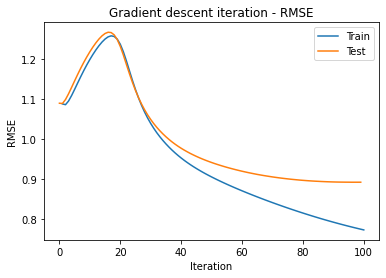

In [ ]:
from matplotlib import pyplot as plt

plt.plot(*zip(*result))
plt.title('Gradient descent iteration - RMSE')
plt.ylabel('RMSE')
plt.xlabel('Iteration')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

#### Prediction

In [ ]:
# Full prediction
# Not able to run in this colab due to out of memory but it was working on 100k dataset 
# print(mf.full_prediction())

In [ ]:
# One prediction 
output = [mf.get_one_prediction(1,pred) for pred in range(0,6)]
output

[4.733526962605859,
 3.0600065129566154,
 4.329810151161072,
 4.604587675106374,
 4.9540297555337025,
 5.000582586870845]

In [ ]:
df_output = ratings[:6] 
df_output["prediction"] = output
df_output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,userId,movieId,rating,prediction
0,1,1193,5,4.733527
1,1,661,3,3.060007
2,1,914,3,4.329810
3,1,3408,4,4.604588
4,1,2355,5,4.954030
5,1,1197,3,5.000583


In [ ]:
movie = pd.read_csv("/content/drive/MyDrive/651/ml-1m/movies.dat",
                      sep = '::',
                      names = ['movieId','movie', 'genre'],
                      encoding = 'latin-1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [ ]:
df_movie_rating = df_output.merge(movie, how='inner', on='movieId')
df_movie_rating

,userId,movieId,rating,prediction,movie,genre
0,1,1193,5,4.733527,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,3.060007,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,4.329810,My Fair Lady (1964),Musical|Romance
3,1,3408,4,4.604588,Erin Brockovich (2000),Drama
4,1,2355,5,4.954030,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,5.000583,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
